## Data Preparation

In [50]:
import re
import numpy as np
from IPython.display import Image

# tokenize the given doc
def tokenize(text):
    """
    text: a text document for tokenization
    """
    # obtain tokes with atleast 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

# mapping between word/vocabulary and id
def mapping(tokens):
    """
    tokens: all the tokens of a document
    """
    word_to_id = dict()
    id_to_word = dict()
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
        
    return word_to_id, id_to_word

# generate training examples from text using specific window size
def generate_training_data(tokens, word_to_id, window_size):
    """
    word_to_id: mapping between vocabulary and its respective id
    window_size: how many related words(before and after) you want to consider 
    """
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        # indices of related words before a word 
        prev_inds = list(range(max(0, i - window_size), i))
        # indices of related words after a word
        next_inds = list(range(min(N, i + window_size + 1), i + 1))
        inds = prev_inds + next_inds
        
        # generate training examples
        for j in inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    # convert to arrays and expand dimensions
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)

    return X, Y

## Word2vec Model Representation

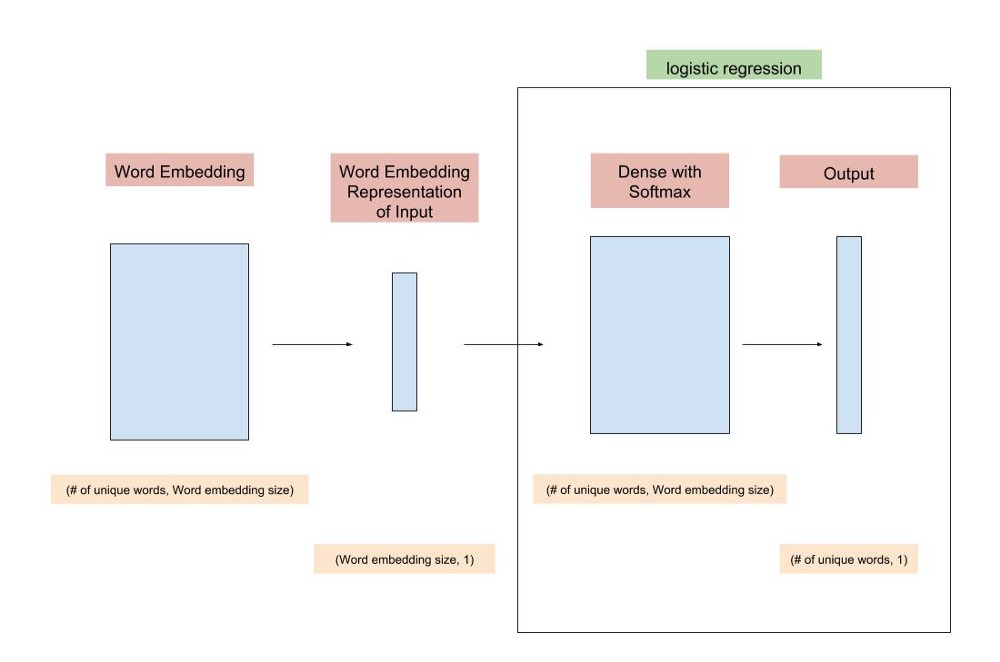

In [49]:
Image(filename = "C:/Users/VenD/Downloads/word2vec/word2vec_skipgram.jpeg", width = 700, height = 700)

In [35]:
# dummy document on which word2vec will be applied
doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."

tokens = tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
# vocab size
vocab_size = len(id_to_word)
# no. of training instances
m = Y.shape[1]

# turn Y into one-hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

## Initialization

In [15]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. Vocabulary size of your corpus or training data
    emb_size: int. How many dimensions to represent each vocabulary
    """
    
    # initialize paramters of word_embedding layer
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    
    assert(WRD_EMB.shape == (vocab_size, emb_size))
    
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of input to the dense layer
    output_size: int. size of output out of the dense layer
    """
    
    # initialize parameters of dense layer
    W = np.random.randn(output_size, input_size) * 0.01
    
    assert(W.shape == (output_size, input_size))
    
    return W

def initialize_parameters(vocab_size, emb_size):
    """
    initialize all the training parameters
    """
    
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

## Forward Propagation

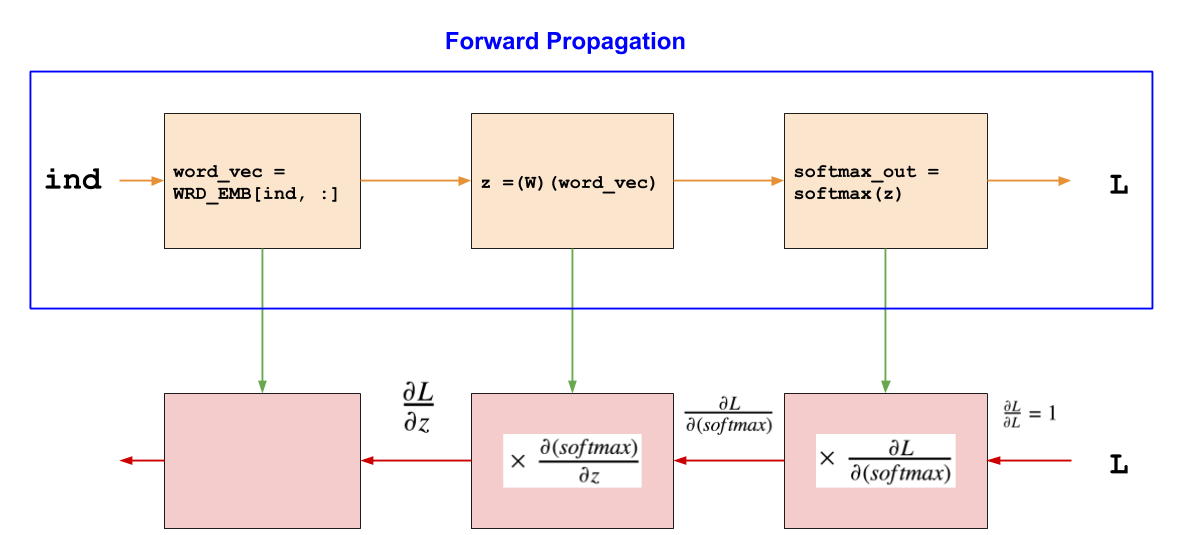

In [53]:
Image(filename = "C:/Users/VenD/Downloads/word2vec/forward_pass.png", width = 900, height = 700)

In [16]:
# By multiplying the word embedding matrix and the one-hot vector, we can get the 
# vector representing the input word. However, the result of performing matrix 
# multiplication is essentially the same as selecting the ith row of the word 
# embedding matrix. We can save lots of computational time by simply selecting the 
# row associating with the input word.

# ============  FORWARD PROPAGATION ===============

def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    
    # each column will represent a word_vec
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec


def linear_dense(word_vec, parameters):
    """
    word_vec: numpy_array. shape:(emb_size, m)
    paremeters: dict. weights to be trained
    """
    
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output of dense layer. shape: (vocab_size, m)
    """
    
    softmax_output = np.divide(np.exp(Z), np.sum(np.exp(Z), axis = 0, keepdims = True) + 0.001)
    
    assert(softmax_output.shape == Z.shape)
    
    return softmax_output

def forward_propagation(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_output = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['Z'] = Z
    caches['W'] = W
    
    return softmax_output, caches

## Cost Function

In [17]:
# =========== computation of cost(L) ===========

def cross_entropy(softmax_output, Y):
    """
    softmax_output: output of softmax(prediction), shape: (vocab_size, m)
    Y: acutal output, shape: (vocab_size, m)
    """
    
    m = softmax_output.shape[1]
    
    # cost function
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_output + 0.001), axis = 0, keepdims = True), axis = 1)
    
    return cost 

## Backward Propagation

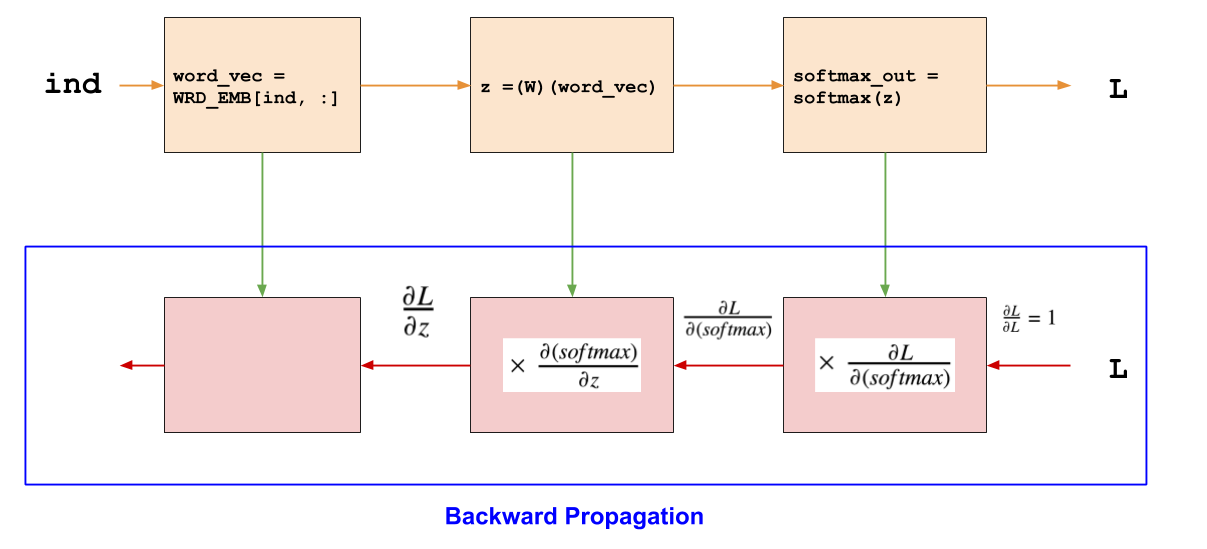

In [54]:
Image(filename = "C:/Users/VenD/Downloads/word2vec/backward_pass.png", width = 900, height = 700)

In [36]:
# =========== BACKWARD PROPAGATION ============

def softmax_backward(Y, softmax_output):
    """
    Y: labels of training data, shape: (vocab_size, m)
    softmax_out: output out of softmax, shape: (vocab_size, m)
    """
    
    dL_dZ = softmax_output - Y
    
    assert(dL_dZ.shape == softmax_output.shape)
    
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: gradient w.r.t softmax, shape: (vocab_size, m)
    caches: dict, results from each steps of forward propagation
    """
    
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    # gradients of dense layer
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    # gradients of word_embedding layer
    dL_dword_vec = np.dot(W.T, dL_dZ)
    
    assert(dL_dW.shape == W.shape)
    assert(dL_dword_vec.shape == word_vec.shape)
    
    return dL_dW, dL_dword_vec


def backward_propagation(Y, softmax_output, caches):
    
    dL_dZ = softmax_backward(Y, softmax_output)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    WRD_EMB = parameters['WRD_EMB']
    W = parameters['W']
    dL_dword_vec = gradients['dL_dword_vec']
    dL_dW = gradients['dL_dW']
    
    m = inds.shape[-1]
    
    # update parameters of both dense and embedding layer using Gradient Descent Algorithm
    WRD_EMB[inds.flatten(), :] -= learning_rate * dL_dword_vec.T
    W -= learning_rate * dL_dW
    

## Training

In [19]:
# ============= MODEL TRAINING ==============

from datetime import datetime
import matplotlib.pyplot as plt

def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size = 256, 
                            parameters = None, print_cost = False, plot_cost = False):
    
    """
    X: input, shape: (1, m)
    Y: One-hot encoding of output word indices, shape: (vocab_size, m)
    vocab_size: vocabulary size of your corpus or training data
    emb_size: word embedding size. How many dimensions to represent each vocabulary
    learning_rate: used in weight update formula. Tells how fast or slow you want to converge.
    epochs: how many epochs to train the model
    batch_size: size of mini batch used in training
    parameters: pre-trained or pre-initialized parameters
    print_cost: whether or not to print the cost during training
    print_cost: whether or not to plot the cost after training
    """
    
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
        
    begin_time = datetime.now()
    
    for epoch in range(epochs):
        epoch_cost = 0
        
        # extract the starting index of all possible batches
        batch_inds = list(range(0, m, batch_size))
        
        # shuffles the batches
        np.random.shuffle(batch_inds)
        
        # train model(forward + backward) by using mini-batches
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]
            
            # forward + backward pass
            softmax_output, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_output, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_output, Y_batch)
            # remove single dimensional entries from cost
            epoch_cost += np.squeeze(cost)
            
        # track cost of each epoch
        costs.append(epoch_cost)
        
        if print_cost and epoch % 100 == 0:
            print("Cost after epoch {} : {}".format(epoch, epoch_cost))
            
        # learning_rate decay after every 50 epochs
        if epoch % 50 == 0:
            learning_rate *= 0.98
            
    end_time = datetime.now()
        
    print("training time {}".format(end_time - begin_time))
        
    # plot epoch vs cost
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel("# of epochs")
        plt.ylabel("cost")
            
    return parameters

Cost after epoch 0 : 2.552184054219967
Cost after epoch 100 : 2.536436680049912
Cost after epoch 200 : 2.413097060755625
Cost after epoch 300 : 2.0666821743036112
Cost after epoch 400 : 1.8424598322920516
Cost after epoch 500 : 1.7334249504281203
Cost after epoch 600 : 1.67837150472223
Cost after epoch 700 : 1.662139046173228
Cost after epoch 800 : 1.6644967918686253
Cost after epoch 900 : 1.6723720021668502
Cost after epoch 1000 : 1.679938408227007
Cost after epoch 1100 : 1.6845620069305272
Cost after epoch 1200 : 1.6854592114253022
Cost after epoch 1300 : 1.6838951601787953
Cost after epoch 1400 : 1.6814757561800364
Cost after epoch 1500 : 1.6791679611407961
Cost after epoch 1600 : 1.6773371495690619
Cost after epoch 1700 : 1.675876068532062
Cost after epoch 1800 : 1.674394877450814
Cost after epoch 1900 : 1.6724871240327057
Cost after epoch 2000 : 1.669924281104417
Cost after epoch 2100 : 1.6666914664192731
Cost after epoch 2200 : 1.6629044578477261
Cost after epoch 2300 : 1.6587050

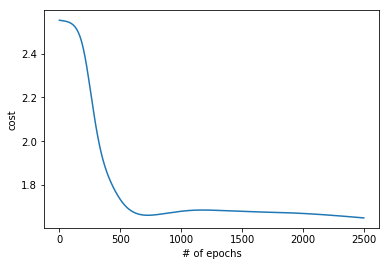

In [37]:
# train the model and save parameters
parameters = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 2500, batch_size = 128, 
                                     parameters = None, print_cost = True, plot_cost = True)

## Evaluation

In [38]:
X_test = np.arange(vocab_size)
X_test =np.expand_dims(X_test, axis = 0)
softmax_test, _ = forward_propagation(X_test, parameters)
# top 4 most related words
top_sorted_inds = np.argsort(softmax_test, axis = 0)[-4:, :]

In [39]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    # select words index in reverse order
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    
    print("{} neighbour words: {}".format(input_word, output_words))

game neighbour words: ["loser's", 'a', 'is', 'game']
is neighbour words: ['market', 'stock', 'the', 'beating']
beating neighbour words: ['investing', 'of', 'costs', 'deduction']
stock neighbour words: ['the', 'beating', 'of', 'after']
of neighbour words: ['costs', 'the', 'of', 'after']
deduction neighbour words: ['the', 'beating', 'of', 'after']
costs neighbour words: ['the', 'beating', 'of', 'after']
after neighbour words: ['the', 'stock', 'is', "loser's"]
a neighbour words: ['is', 'market', 'stock', 'the']
the neighbour words: ['beating', 'of', 'investing', 'after']
investing neighbour words: ['of', 'costs', 'deduction', 'after']
loser's neighbour words: ['a', 'is', 'market', 'stock']
market neighbour words: ['stock', 'beating', 'the', 'market']
